The MIT License (MIT)

Copyright (c) 2020 Weizmann Institute of Science
Copyright (c) 2020 Elad Noor

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

In [2]:
import argparse
import logging
import os
import re
import sys

import numpy as np
from cobra.io import read_sbml_model
import pandas as pd
from sbtab import SBtab
from equilibrator_api import Q_, ComponentContribution
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
cobra_model = read_sbml_model("iML1515.xml.gz")

Restricted license - for non-production use only - expires 2024-10-28


In [4]:
# collect the stats from the solution file
stats_data = []
reaction_data = []
all_reaction_ids = set()

sbtabdoc = SBtab.read_csv(f"pathways.tsv", "solutions")
for sbtab in sbtabdoc.sbtabs:
    if sbtab.table_type == "Reaction":
        i = int(re.findall("Pathway_(\d+)_reactions", sbtab.table_name)[0])
        d = {"pathways": i}
        for row in sbtab.to_data_frame().itertuples():
            all_reaction_ids.add(row.reaction_id)
            flux = float(row.primal)
            if flux > 0:
                d[row.reaction_id + "_F"] = flux
            elif flux < 0:
                d[row.reaction_id + "_R"] = -flux
        reaction_data.append(d)
    
    if sbtab.table_type == "Quantity":
        i = int(re.findall("Pathway_(\d+)_stats", sbtab.table_name)[0])
        df = sbtab.to_data_frame().set_index("ID")
        mdf = Q_(float(df.at["mdf", "Value"]), units=df.at["mdf", "Unit"])
        sum_of_fluxes = float(df.at["sum_flux", "Value"])
        n_reactions = float(df.at["nr", "Value"])
        stats_data.append((i, mdf, sum_of_fluxes, n_reactions))

stats_df = pd.DataFrame(
    data=stats_data,
    columns=["pathways", "mdf", r"$\Sigma |v_i|$", "n_reactions"]
).set_index("pathways")

reaction_df = pd.DataFrame.from_dict(reaction_data).set_index("pathways").fillna(0.0)

In [4]:
# DEBUG: write the list of all the reactions used in all the pathways
pd.DataFrame(data=[(rxn.id, rxn.name, rxn.reaction)
                   for rxn in map(cobra_model.reactions.get_by_id, all_reaction_ids)],
                   columns=["bigg_id", "name", "formula"]).to_csv(f"pathways_reactions.csv")
pd.merge(stats_df, reaction_df, left_index=True, right_index=True).to_csv(f"pathways_summary.csv")

In [5]:
# find the names of all the carboxylating enzymes
rxn_carb = set()
for rxn in cobra_model.metabolites.co2_c.reactions:
    if cobra_model.metabolites.co2_c in rxn.reactants:
        rxn_carb.add(rxn.id + "_F")
    elif cobra_model.metabolites.co2_c in rxn.products:
        rxn_carb.add(rxn.id + "_R")
    else:
        raise Exception("internal error")
rxn_carb = list(rxn_carb.intersection(reaction_df.columns))

In [6]:
# write the list of all carboxylases
carb_df_list = []
for co2 in [cobra_model.metabolites.co2_c, cobra_model.metabolites.hco3_c]:
    carb_df_list.append(pd.DataFrame(data=[(rxn.id, rxn.name, co2.name, rxn.reaction, co2 in rxn.reactants)
                                           for rxn in co2.reactions],
                                     columns=["bigg_id", "name", "co2_form", "formula", "forward"]))
carb_df = pd.concat(carb_df_list)

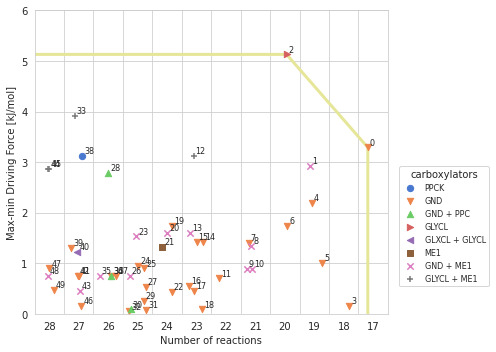

In [7]:
colors = sns.color_palette(palette="muted", n_colors=10)
markers = ["o", "v", "^", ">", "<", "s", "x", "+"] * 5

sns.set_style("whitegrid")

tmp_df = stats_df.copy()
tmp_df["y"] = stats_df.mdf.apply(lambda x: (x/Q_("kJ/mol")).magnitude)
tmp_df["x"] = stats_df.n_reactions.apply(int) + 0.6 * (np.random.rand(stats_df.shape[0]) - 0.5)
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
for (group, group_df), color, marker in zip((reaction_df[rxn_carb] != 0).groupby(rxn_carb), colors, markers):
    label = " + ".join(sorted([r for r, c in zip(rxn_carb, group) if c is True]))
    label = label.replace("_R", "")
    label = label.replace("_F", "")    
    idx = group_df.index
    y = tmp_df.loc[idx, "y"]
    x = tmp_df.loc[idx, "x"]
    ax.scatter(x=x, y=y, s=40, color=color, marker=marker, label=label, alpha=1, zorder=2)
    for row in group_df.itertuples():
        ax.text(x.at[row.Index]-0.07, y.at[row.Index]+0.05, f"{row.Index}", fontsize=8)
    
maxx = int(tmp_df.n_reactions.max())
minx = int(tmp_df.n_reactions.min())
ax.set_xticks(range(minx, maxx+1))
ax.set_xlim(maxx+0.5, minx-0.5)
ax.set_ylim(0, np.ceil(tmp_df.y.max()))

for i in range(minx, maxx):
    ax.axvline(x=i+0.5, ls="-", linewidth=1, color="grey", alpha=0.3, zorder=0)
ax.xaxis.grid(False)

# depict the Pareto front somehow
pareto_y = tmp_df.sort_values(by=["y", "x"], ascending=[False, True]).iloc[0, :]
pareto_x = tmp_df.sort_values(by=["x", "y"], ascending=[True, False]).iloc[0, :]
ax.plot([tmp_df.x.min(), pareto_x.x, pareto_y.x, maxx+0.5],
        [0, pareto_x.y, pareto_y.y, tmp_df.y.max()],
        color=(0.9, 0.9, 0.6), alpha=1, linewidth=3, zorder=1)

ax.legend(title="carboxylators", fontsize=8, bbox_to_anchor=(1.02, 0.5))
ax.set_xlabel("Number of reactions")
ax.set_ylabel("Max-min Driving Force [kJ/mol]")

fig.tight_layout()
fig.savefig(f"figureX1.pdf", format="pdf")

## Draw all pathways using graphviz

In [8]:
from solution import Solution

cofactors = set(map(cobra_model.metabolites.get_by_id, [
    "adp_c", "atp_c", "co2_c", "o2_c", "pi_c", "nh4_c", "glu__L_c",
    "akg_c", "h_c", "h_p", "h_e", "h2o_c", "nad_c", "nadh_c",
    "nadp_c", "nadph_c", "trdox_c", "trdrd_c", "q8_c", "q8h2_c", "mqn8_c", "mql8_c"
]))

In [9]:
if not os.path.exists("gdot"):
    os.mkdir("gdot")

pathway_data = []
for row in stats_df.itertuples():
    df = reaction_df.loc[row.Index, :].reset_index().rename(columns={"index": "reaction_id", row.Index: "primal"})
    df["type"] = "flux"
    df["lp_type"] = "variable"
    df["name"] = "R@flux@" + df.reaction_id
    df["primal"] = df.primal.apply(float)
    sol = Solution(row.Index, cobra_model, cofactors, df, row.mdf)
    g_dot, r_nodes, m_nodes = sol.to_graph()
    g_dot.write_pdf(f"gdot/pathway{row.Index:d}.pdf")

In [10]:
_df = reaction_df.loc[:, rxn_carb].copy()
_df.index.name = "pathway"
_df.columns = _df.columns.map(lambda s: s.replace("_R", "").replace("_F", ""))
_df = _df.reset_index()
_df = _df.melt(id_vars="pathway", var_name="carboxylators", value_name="flux")
_df = _df[_df.flux > 0]
_df = _df.groupby("pathway")["carboxylators"].apply(lambda text: ' + '.join(text))
stats_df = _df.to_frame().join(stats_df, on="pathway")
stats_df.to_csv("tableX2.csv")

In [11]:
# make a LaTeX table with the pathway statistics
print("Pathway & MDF [kJ/mol] & No. reactions & Carboxylating reactions \\\\")
print("\\hline")
carb_df = reaction_df.loc[:, rxn_carb]
for row in stats_df.itertuples():
    print(f"{row.Index} & {row.mdf.magnitude} & {row.n_reactions} & {row.carboxylators}\\\\")

Pathway & MDF [kJ/mol] & No. reactions & Carboxylating reactions \\
\hline
0 & 3.29 & 17.0 & GND\\
1 & 2.93 & 19.0 & ME1 + GND\\
2 & 5.13 & 20.0 & GLYCL\\
3 & 0.16 & 18.0 & GND\\
4 & 2.19 & 19.0 & GND\\
5 & 1.01 & 19.0 & GND\\
6 & 1.74 & 20.0 & GND\\
7 & 1.4 & 21.0 & GND\\
8 & 1.35 & 21.0 & ME1 + GND\\
9 & 0.89 & 21.0 & ME1 + GND\\
10 & 0.89 & 21.0 & ME1 + GND\\
11 & 0.7 & 22.0 & GND\\
12 & 3.12 & 23.0 & ME1 + GLYCL\\
13 & 1.6 & 23.0 & ME1 + GND\\
14 & 1.42 & 23.0 & GND\\
15 & 1.42 & 23.0 & GND\\
16 & 0.55 & 23.0 & GND\\
17 & 0.46 & 23.0 & GND\\
18 & 0.09 & 23.0 & GND\\
19 & 1.74 & 24.0 & GND\\
20 & 1.6 & 24.0 & ME1 + GND\\
21 & 1.32 & 24.0 & ME1\\
22 & 0.43 & 24.0 & GND\\
23 & 1.53 & 25.0 & ME1 + GND\\
24 & 0.95 & 25.0 & GND\\
25 & 0.9 & 25.0 & GND\\
26 & 0.75 & 25.0 & ME1 + GND\\
27 & 0.53 & 25.0 & GND\\
28 & 2.78 & 26.0 & GND + PPC\\
29 & 0.26 & 25.0 & GND\\
30 & 0.09 & 25.0 & GND + PPC\\
31 & 0.08 & 25.0 & GND\\
32 & 0.05 & 25.0 & GND\\
33 & 3.92 & 27.0 & ME1 + GLYCL\\
34 & 0.75 & 